# Using Vanna with a Local Context Database
Generally it's a lot easier to get started with Vanna using our hosted service. However, if you want to run Vanna locally, you can do so by running a local context database using ChromaDB. This notebook will walk you through the steps to do so.

In [ ]:
%pip install 'vanna[chromadb,snowflake,openai]'

In [1]:
from vanna.local import LocalContext_OpenAI

# Configure OpenAI API Key
If you're using Azure OpenAI there are some additional parameters to specify beyond the API Key

In [2]:
# Use the regular OpenAI API
vn = LocalContext_OpenAI({"api_key": "sk-..."})

# Use the Azure OpenAI API
vn = LocalContext_OpenAI(config={
    "api_type": "azure",
    "api_base": "https://...",
    "api_version": "2023-05-15",
    "engine": "YOUR_ENGINE_HERE",
    "api_key": "sk-..."
})

# Train using a Sample SQL Query
The easiest way to get started is to just paste in one SQL query and let Vanna train on it. This will create a new context database and train a model on it. You can then use that model to generate SQL queries.

In [3]:
vn.train(sql="""
SELECT c.c_name as customer_name,
       sum(l.l_extendedprice * (1 - l.l_discount)) as total_sales
FROM   snowflake_sample_data.tpch_sf1.lineitem l join snowflake_sample_data.tpch_sf1.orders o
        ON l.l_orderkey = o.o_orderkey join snowflake_sample_data.tpch_sf1.customer c
        ON o.o_custkey = c.c_custkey
GROUP BY customer_name
ORDER BY total_sales desc limit 5;
""")

Using model gpt-3.5-turbo for 147.5 tokens (approx)
Question generated with sql: What are the top 5 customers in terms of total sales? 
Adding SQL...


# Connect to the Database
This is the database that will be used to run the generated SQL queries against. Here we're connecting to Snowflake.

In [ ]:
vn.connect_to_snowflake(account='my-account', username='my-username', password='my-password', database='my-database')

# Begin Asking Questions
There is an automatic feedback loop here so when you ask a question that results in SQL that can execute, it will automatically be added to the context database and used to train the model.

Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1


Using model gpt-3.5-turbo for 167.0 tokens (approx)
SELECT c.c_name as customer_name,
       sum(l.l_extendedprice * (1 - l.l_discount)) as total_sales
FROM   snowflake_sample_data.tpch_sf1.lineitem l join snowflake_sample_data.tpch_sf1.orders o
        ON l.l_orderkey = o.o_orderkey join snowflake_sample_data.tpch_sf1.customer c
        ON o.o_custkey = c.c_custkey
GROUP BY customer_name
ORDER BY total_sales desc limit 10;


,CUSTOMER_NAME,TOTAL_SALES
0,Customer#000143500,6757566.0218
1,Customer#000095257,6294115.3340
2,Customer#000087115,6184649.5176
3,Customer#000131113,6080943.8305
4,Customer#000134380,6075141.9635
5,Customer#000103834,6059770.3232
6,Customer#000069682,6057779.0348
7,Customer#000102022,6039653.6335
8,Customer#000098587,6027021.5855
9,Customer#000064660,5905659.6159


Using model gpt-3.5-turbo for 259.25 tokens (approx)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


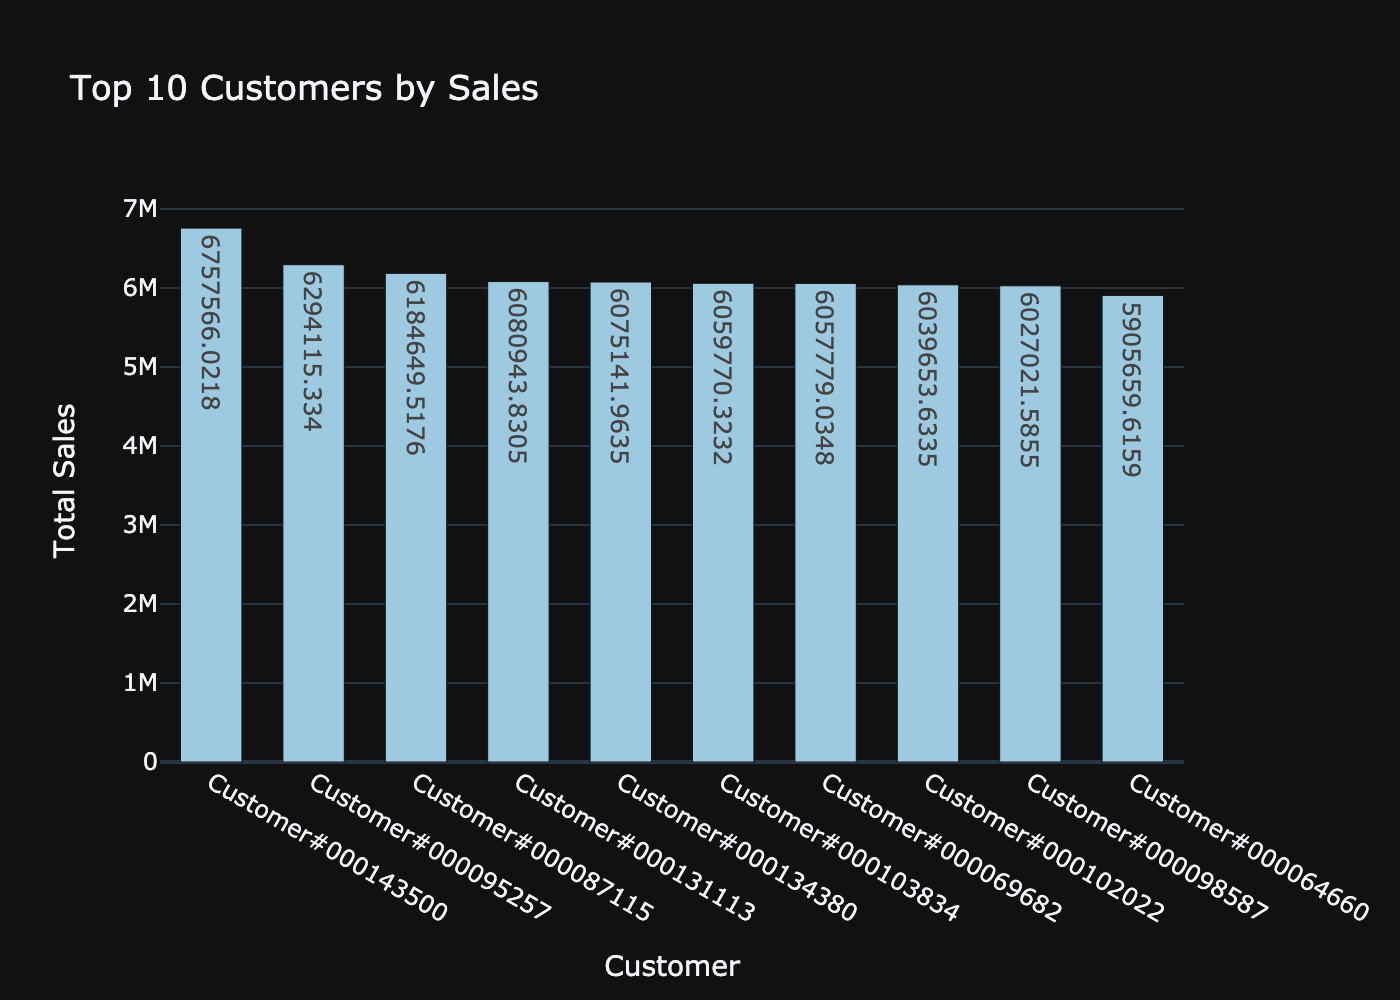

In [5]:
vn.ask("What are the top 10 customers by sales?")

# Training Plan
A training plan is a great way to extract metadata from your database to use for training. You specify which databases and schemas to filter on and it will attempt to retrieve past queries from the query history as well as the table and column names from the information schema.

In [6]:
training_plan = vn.get_training_plan_snowflake(filter_databases=['SNOWFLAKE_SAMPLE_DATA'], filter_schemas=['TPCH_SF1'])
training_plan

Trying query history
Using model gpt-3.5-turbo for 147.25 tokens (approx)
Using model gpt-3.5-turbo for 168.25 tokens (approx)
Using model gpt-3.5-turbo for 147.0 tokens (approx)
Using model gpt-3.5-turbo for 147.25 tokens (approx)
Trying INFORMATION_SCHEMA.DATABASES
Trying INFORMATION_SCHEMA.COLUMNS for SNOWFLAKE_SAMPLE_DATA


Train on SQL:  What are the top 10 customers based on their total sales?
Train on SQL:  What are the top 10 countries with the highest total sales?
Train on SQL:  What are the top 5 customers based on their total sales?
Train on SQL:  What are the top 15 customers based on their total sales?
Train on Information Schema: SNOWFLAKE_SAMPLE_DATA.TPCH_SF1 CUSTOMER
Train on Information Schema: SNOWFLAKE_SAMPLE_DATA.TPCH_SF1 SUPPLIER
Train on Information Schema: SNOWFLAKE_SAMPLE_DATA.TPCH_SF1 LINEITEM
Train on Information Schema: SNOWFLAKE_SAMPLE_DATA.TPCH_SF1 PARTSUPP
Train on Information Schema: SNOWFLAKE_SAMPLE_DATA.TPCH_SF1 PART
Train on Information Schema: SNOWFLAKE_SAMPLE_DATA.TPCH_SF1 ORDERS
Train on Information Schema: SNOWFLAKE_SAMPLE_DATA.TPCH_SF1 REGION
Train on Information Schema: SNOWFLAKE_SAMPLE_DATA.TPCH_SF1 NATION

In [7]:
vn.train(plan=training_plan)

# Ask More Questions!
Now that you have a fuly trained model, you can continue asking questions and it will continue to learn and improve.

In [ ]:
vn.ask()